In [ ]:
from joblib import Parallel, delayed
import os
os.environ['R_HOME'] = '/datapool/home/zhijian/zhijian/miniconda3/envs/circadian/lib/R'
# os.environ['R_HOME'] = '/public/home/liuzj/softwares/anaconda3/envs/hormone/lib/R'
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
from jpy_tools.rTools import py2r, r2py, r_inline_plot, rHelp, trl, rSet, rGet, ad2so, so2ad, so2md, rcontext, Trl, r2py_re, py2r_re, RR, FR
from jpy_tools import loadPkl, toPkl
rBase = importr('base')
rUtils = importr('utils')
dplyr = importr('dplyr')
reticulate = importr('reticulate')
R = ro.r
T = Trl()
R("options(browser='firefox', shiny.port=6533, max.print=200)")
%load_ext rpy2.ipython


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

<Figure size 100x100 with 0 Axes>

In [ ]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import marsilea as ma
import marsilea.plotter as mp
# plt.rcParams['figure.dpi'] = 150
font_dirs = ["/datapool/home/zhijian/.local/share/mpl_fontkit/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
sns.despine(top=True, right=True)
from itertools import product
from functools import reduce
import patchworklib as pw
from jpy_tools.otherTools import pwRecoverSeaborn, pwStack, F, pwShow
pw.show = pwShow
fc_recoverSns = pwRecoverSeaborn()
import seaborn.objects as so
from cycler import cycler
dt_snsStyle = {**sns.axes_style('ticks'), "legend.frameon": False, "axes.spines.top":False, "axes.spines.right":False, "axes.prop_cycle":cycler(color=['grey'])}
so.Plot.config.theme.update(dt_snsStyle)
from jpy_tools.soExt import Axhline, Axvline, mvLegToAx
from jpy_tools import soExt
plt.set_loglevel('Warning')

<Figure size 640x480 with 0 Axes>

In [ ]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import scipy.sparse as ss
from tqdm import tqdm
from loguru import logger
from functools import partial
from jpy_tools import singleCellTools

In [ ]:
from jpy_tools.otherTools import FigConcate, FigConcateWrap

In [ ]:
dir_result = "/datapool/home/zhijian/zhijian/ipf/circadian_data/"

In [ ]:
ead = singleCellTools.EnhancedAnndata(
    loadPkl(
        "beforeQc",
        lambda **dt: sc.read_h5ad(**dt),
        arg_path="filename",
        dir_path=dir_result,
    )
)

2024-07-29 15:20:17.026 | WARNING  | jpy_tools.singleCellTools:rawLayer:463 - rawLayer will be overwritten by raw and all the related objects will be re-initialized


## Call Circadian

## JTK

In [ ]:
ad_pb = ead.pl.getPb(["Cluster_final", "CT_raw"])

In [ ]:
from joblib import Parallel, delayed

In [ ]:
ad_pb.obs["CT"] = ad_pb.obs["CT_raw"].map(lambda _: _.split("CT")[-1])

In [ ]:
def getPhase(x, y):
    def _cos(x, a, b, c):
        return a * np.cos((np.pi / 12) * x - (np.pi / 12) * b) + c

    from scipy.optimize import curve_fit

    popt, pcov = curve_fit(_cos, x, y, bounds=([0, 0, 0], [np.inf, 24, np.inf]))
    std = np.sqrt(np.diag(pcov))
    return (*popt, *std)

In [ ]:
def getJtkGene(ad_merge, cluster, layer):
    MetaCycle = importr("MetaCycle")
    ad_test = ad_merge[ad_merge.obs.eval(f"Cluster_final == @cluster", engine="python")]
    sc.pp.filter_genes(ad_test, min_cells=3)
    sr_idxMax = (
        ad_test.to_df(layer).idxmax(axis=0).str.split(f"\|\|").str[-1].rename("idxMax")
    )
    _df = ad_test.to_df(layer).join(ad_test.obs["CT"]).pivot_table(columns=["CT"])
    _df = _df[sorted(_df.columns, key=int)]
    _df.columns = _df.columns.astype(int)
    _df = _df.rename_axis(index="geneName").reset_index()
    outD = MetaCycle.meta2d(
        infile="csv",
        filestyle="csv",
        cycMethod=R.c("JTK"),
        timepoints=R.seq(24, 72, 4),
        outputFile=False,
        inDF=_df >> F(py2r),
        minper=24,
        maxper=24,
    )
    df_jtk = (
        r2py(outD[1])
        .assign(Cluster=cluster)
        .merge(sr_idxMax, left_on="CycID", right_index=True)
    )

    _df_mtx = ad_test.to_df(layer)
    _ls = []
    for gene in df_jtk["CycID"]:
        res = getPhase(ad_test.obs["CT"].astype(int), _df_mtx[gene].values)
        _ls.append(res)

    df_jtk["phase"] = [x[1] for x in _ls]
    df_jtk["phase"] = (np.round(df_jtk["phase"] / 2) * 2).astype(int)
    df_jtk["phase"] = np.where(df_jtk["phase"] == 24, 0, df_jtk["phase"])

    df_jtk["orgPhase"] = [x[1] for x in _ls]
    df_jtk["stdPhase"] = [x[4] for x in _ls]

    df_jtk["orgAmpli"] = [x[0] for x in _ls]
    df_jtk["stdAmpli"] = [x[3] for x in _ls]

    df_jtk["orgBase"] = [x[2] for x in _ls]
    df_jtk["stdBase"] = [x[5] for x in _ls]
    return df_jtk

In [ ]:
lsDf = Parallel(n_jobs=40)(
    delayed(getJtkGene)(ad_pb[:,], cluster, "normalize_log")
    for cluster in ad_pb.obs["Cluster_final"].unique()
)

The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in process from  18:17:14 10-10-2024 
The JTK is in proces

In [ ]:
df_jtkCpmOrg = pd.concat(lsDf)

In [ ]:
# ead.uns["metacycle_normalizeLog_0814"] = df_jtkCpmOrg

In [ ]:
ead.uns["jtk_normalizeLog_0814"] = df_jtkCpmOrg

In [ ]:
del(ead.uns['scshc_Cluster_final_pvalue'])

In [ ]:
toPkl(ead.ad, "afterJtk", "gpu", dir_path=dir_result)

2024-09-02 20:09:06.416 | INFO     | jpy_tools.otherTools:toPkl:482 - please run `loadPkl('afterJtk', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


In [ ]:
ead = singleCellTools.EnhancedAnndata(loadPkl('afterJtk', lambda **dt:sc.read_h5ad(**dt), arg_path='filename', dir_path=dir_result))

2024-09-29 21:47:54.442 | WARNING  | jpy_tools.singleCellTools:rawLayer:463 - rawLayer will be overwritten by raw and all the related objects will be re-initialized


## Analysis

In [ ]:
ead.uns["jtk_normalizeLog_0814"] = ead.uns["jtk_normalizeLog_0814"].loc[~ead.uns["jtk_normalizeLog_0814"]['CycID'].str.contains('C|M')]

In [ ]:
df_jtkCpmOrg = ead.uns["jtk_normalizeLog_0814"].query("`ADJ.P` < 0.05")

### Rank

In [ ]:
df_jtkCpm = df_jtkCpmOrg.copy()

In [ ]:
df_jtkCpm = df_jtkCpm.assign(cluster=lambda _: _.Cluster.astype('category').cat.set_categories(ead.obs['Cluster_final'].cat.categories)).query("CycID.isin(@ls_pubCircadianGenes)")

In [ ]:
df_tfList = pd.read_table(
    "/datapool/home/zhijian/zhijian/projects/circadian_data/Ath_TF_list.txt"
)

In [ ]:
df_jtkCpmForYw = (
    df_jtkCpm.pivot_table("phase", "CycID", "cluster")
    .fillna("")
    .assign(counts=lambda _: _.apply(lambda _: len([x for x in _ if x != ""]), axis=1))
    .sort_values("counts", ascending=False)
)

In [ ]:
df_jtkCpmForYw["TF"] = df_jtkCpmForYw.index.map(
    lambda _: _ in df_tfList["Gene_ID"].to_list()
)

In [ ]:
df_jtkCpmForYw = df_jtkCpmForYw.map(lambda _: str(int(_)) if isinstance(_, float) else _)

In [ ]:
df_jtkCpmForYw

cluster    R0  R1  R2  R3  R4  R5  R6  R7  R8  R9  ...  V0  V1  V2  V3  V4  \
CycID                                              ...                       
AT3G62550  10  10  10  10  10  12  10  10  10  10  ...  12  10  10  12  10   
AT3G26740  10  10  10  10  10  10      10  10  10  ...  10  10  10  10  10   
AT2G05070   4   4   4   4   4   4   2   4       4  ...   4   4   4   4   2   
AT2G43010   6   6   6   6       6       6   4   6  ...   6   6       6   6   
AT2G42530  10  12  12  12  10  12      10      12  ...  10  12      10  12   
...        ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
AT1G01040                                          ...              12       
AT1G01020                                          ...          18           
AT5G66820          12                              ...                       
AT5G66270                                          ...                       
AT5G66420                      12                  ...                       

cluster    U0  U1  U2 counts     TF  
CycID                                
AT3G62550  12  12  10     40  False  
AT3G26740  12  10  10     39  False  
AT2G05070   2   4   2     37  False  
AT2G43010   4   6   6     37   True  
AT2G42530  12  12  10     37  False  
...        ..  ..  ..    ...    ...  
AT1G01040                  1  False  
AT1G01020                  1  False  
AT5G66820                  1  False  
AT5G66270                  1  False  
AT5G66420                  1  False  

[9832 rows x 42 columns]

In [ ]:
df_jtkCpmForYw.to_excel(f"{dir_result}/jtkCpmForYw_1010.xlsx")

In [ ]:
df_jtkCpmForYw

cluster    R0  R1  R2  R3  R4  R5  R6  R7  R8  R9  ...  V0  V1  V2  V3  V4  \
CycID                                              ...                       
AT3G62550  10  10  10  10  10  12  10  10  10  10  ...  12  10  10  12  10   
AT3G26740  10  10  10  10  10  10      10  10  10  ...  10  10  10  10  10   
AT2G05070   4   4   4   4   4   4   2   4       4  ...   4   4   4   4   2   
AT2G43010   6   6   6   6       6       6   4   6  ...   6   6       6   6   
AT2G42530  10  12  12  12  10  12      10      12  ...  10  12      10  12   
...        ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
AT1G01040                                          ...              12       
AT1G01020                                          ...          18           
AT5G66820          12                              ...                       
AT5G66270                                          ...                       
AT5G66420                      12                  ...                       

cluster    U0  U1  U2 counts     TF  
CycID                                
AT3G62550  12  12  10     40  False  
AT3G26740  12  10  10     39  False  
AT2G05070   2   4   2     37  False  
AT2G43010   4   6   6     37   True  
AT2G42530  12  12  10     37  False  
...        ..  ..  ..    ...    ...  
AT1G01040                  1  False  
AT1G01020                  1  False  
AT5G66820                  1  False  
AT5G66270                  1  False  
AT5G66420                  1  False  

[9832 rows x 42 columns]

In [ ]:
def _getClusterTissue(x):
    if x.startswith('R'):
        return 'Root'
    elif x.startswith('S'):
        return 'Shoot'
    elif x.startswith('V'):
        return 'Stele'
    elif x.startswith('U'):
        return 'Unknown'
    else:
        assert False

In [ ]:
df_jtkCpm.value_counts("cluster").sort_index()

cluster
R0      660
R1      804
R2      615
R3      394
R4      384
R5      307
R6      223
R7      521
R8      284
R9      320
R10     381
R11     504
R12     362
R13     297
R14     476
R15     323
S0     3363
S1     2738
S2     3956
S3     2333
S4     1465
S5     1068
S6     1213
S7     2342
S8     1006
S9      750
S10    1317
S11    1510
S12    1504
S13     707
S14     663
S15     710
V0      427
V1      429
V2      367
V3      656
V4      670
U0      516
U1      450
U2      239
Name: count, dtype: int64

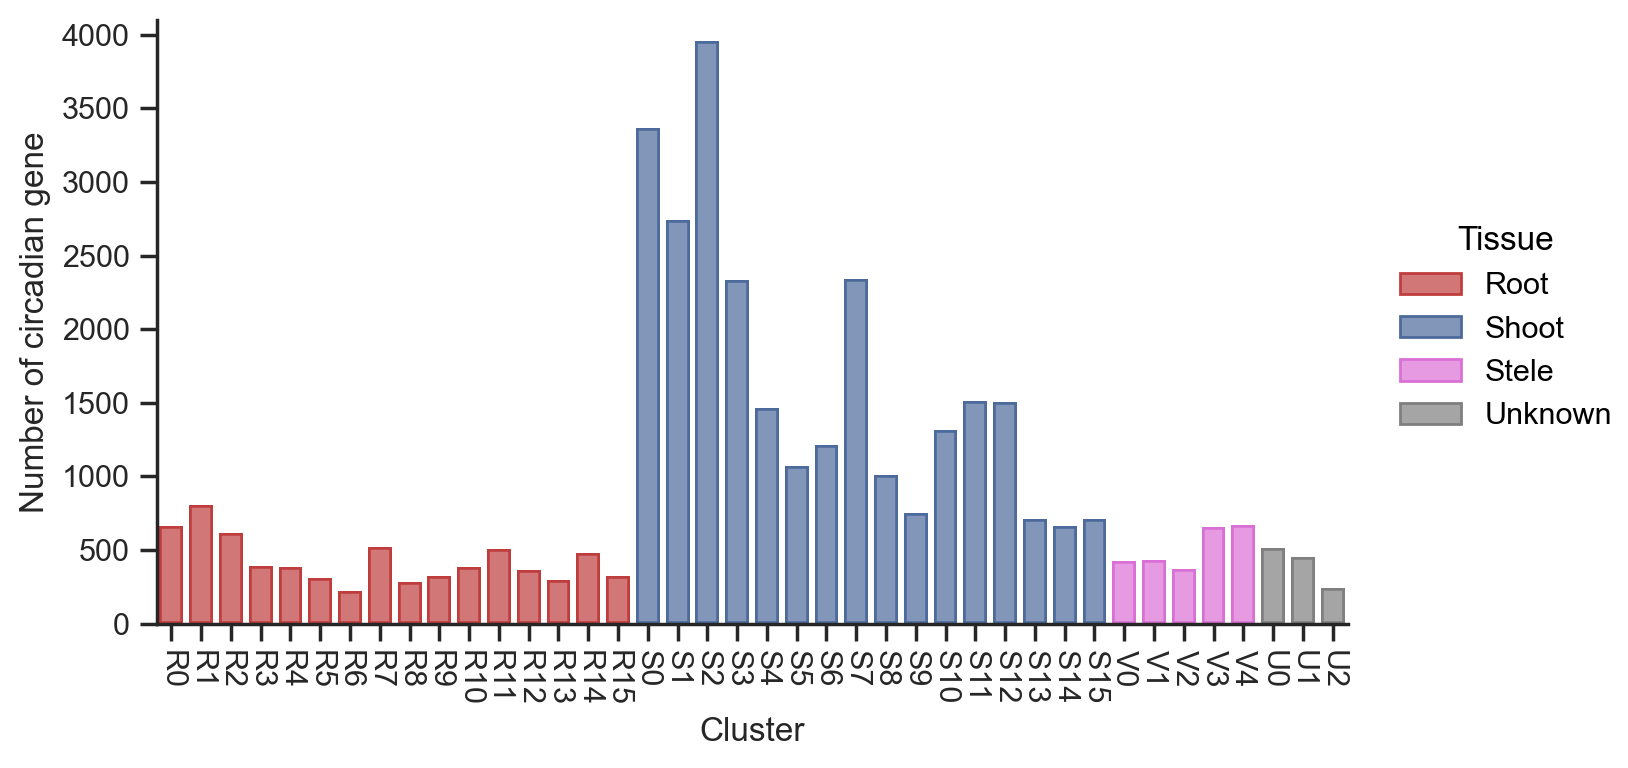

In [ ]:
p = df_jtkCpm.value_counts("cluster").sort_index() >> F(
    lambda _: so.Plot(x=_.index, y=_, color=_.index.map(_getClusterTissue))
    .add(
        so.Bar(),
    )
    .label(x="Cluster", y="Number of circadian gene", color='Tissue')
    .limit(y=(0, 4100))
    .layout(size=(7, 4))
    .scale(color={
        'Root': '#c03d3e', 'Shoot': '#4c6a9c', 'Stele': '#da70d6', 'Unknown': '#7f7f7f'
    })
)
fig = p.plot()._figure
ax = fig.axes[0]
# rotate xlabel
ax.get_xticklabels() >> F(map, lambda _: _.set(rotation=-90, ha='center')) >> F(list)
fig

# Gene in different Cluster

In [ ]:
ead.pl.getPb(["CT_raw"]).obs["CT"] = (
    ead.pl.getPb(["CT_raw"]).obs["CT_raw"].map(lambda _: _[2:])
)

2024-09-02 16:50:42.666 | WARNING  | jpy_tools.singleCellTools.basic:testAllCountIsInt:318 - Make sure that adata.layer contains unnormalized count data	Layer:raw


In [ ]:
df_jtkCpm

CycID  ARS_pvalue  ARS_BH.Q  ARS_period  ARS_adjphase  \
5      AT1G01050    0.022932  0.465746        24.0     20.450081   
6      AT1G01060    0.009370  0.388094        24.0      0.278410   
10     AT1G01100    0.008662  0.376620        24.0     19.994564   
15     AT1G01160    0.015724  0.428838        24.0     13.858113   
57     AT1G01630    0.040733  0.528366        24.0      0.715126   
...          ...         ...       ...         ...           ...   
16928  AT5G65920    0.047020  0.957732        24.0     11.480342   
16941  AT5G66052    0.029678  0.957732        24.0     14.880364   
16959  AT5G66280    0.019439  0.946510        24.0      1.143580   
16961  AT5G66310    0.099770  0.957732        24.0      5.294068   
17174  ATMG01170    0.033927  0.957732        24.0      2.889371   

       ARS_amplitude  JTK_pvalue  JTK_BH.Q  JTK_period  JTK_adjphase  ...  \
5           0.195056    0.129490       1.0        24.0           0.0  ...   
6           1.110986    0.060704       1.0        24.0           0.0  ...   
10          0.177580    0.253091       1.0        24.0          22.0  ...   
15          0.201173    0.089701       1.0        24.0          16.0  ...   
57          0.218719    0.089701       1.0        24.0           2.0  ...   
...              ...         ...       ...         ...           ...  ...   
16928       0.909114    0.040064       1.0        24.0          12.0  ...   
16941       1.096482    0.016053       1.0        24.0          14.0  ...   
16959       0.414322    0.089701       1.0        24.0           2.0  ...   
16961       0.773055    0.040064       1.0        24.0           8.0  ...   
17174       1.161791    0.040064       1.0        24.0           2.0  ...   

       Cluster  idxMax  phase   orgPhase  stdPhase  orgAmpli  stdAmpli  \
5           R0      R0     20  20.718634  1.395780  0.178688  0.065983   
6           R0      R0      0   0.422819  1.044383  1.114859  0.284273   
10          R0      R0     20  20.454058  1.622863  0.147822  0.064082   
15          R0      R0     14  14.015103  1.064591  0.205819  0.055377   
57          R0      R0      0   0.494223  1.406175  0.216709  0.074447   
...        ...     ...    ...        ...       ...       ...       ...   
16928       U2      U2     12  12.284779  1.640697  0.903223  0.361463   
16941       U2      U2     14  14.857791  1.217775  1.090448  0.345806   
16959       U2      U2      0   0.414475  1.483356  0.398234  0.144215   
16961       U2      U2      6   5.403726  1.229534  0.913730  0.314843   
17174       U2      U2      4   3.000248  1.177264  1.195025  0.368318   

        orgBase   stdBase  cluster  
5      5.863309  0.046415       R0  
6      4.859238  0.208404       R0  
10     8.644798  0.044863       R0  
15     5.449632  0.039866       R0  
57     5.995483  0.054559       R0  
...         ...       ...      ...  
16928  3.204624  0.265128       U2  
16941  3.713420  0.245174       U2  
16959  5.343949  0.105729       U2  
16961  4.379936  0.215426       U2  
17174  1.586001  0.260439       U2  

[66571 rows x 33 columns]

In [ ]:
for ax in h.figure.axes:
    print(ax.texts)

<Axes.ArtistList of 0 texts>
<Axes.ArtistList of 13 texts>
<Axes.ArtistList of 1 texts>
<Axes.ArtistList of 1 texts>
<Axes.ArtistList of 40 texts>
<Axes.ArtistList of 0 texts>
<Axes.ArtistList of 0 texts>
<Axes.ArtistList of 1 texts>
<Axes.ArtistList of 0 texts>


In [ ]:
h.figure.axes[-2]

Text(0.5, 0.5, 'PRR9')

In [ ]:
ax.xaxis.label.set_visible(True)
ax.xaxis.set_tick_params(labelbottom=True)

[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]


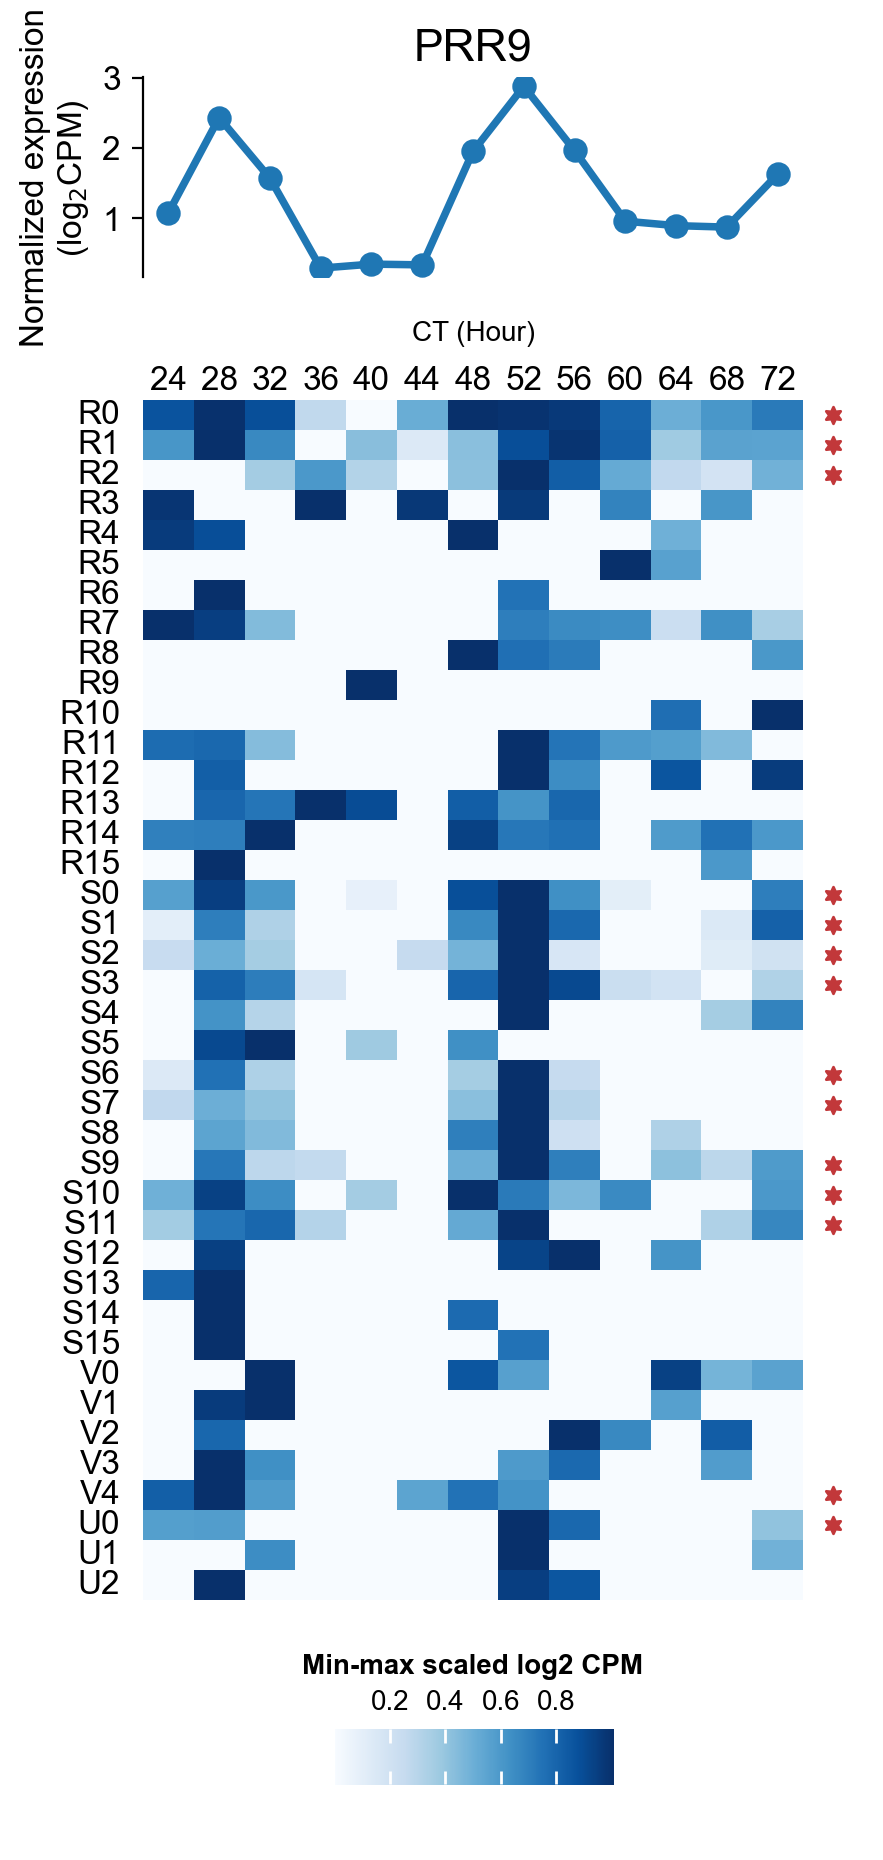

In [ ]:
h = plotGeneUsingCircadianStyle(ead, "AT2G46790", df_jtkCpm, name="PRR9")
ax = h.figure.axes[-3]
ax.set_ylabel("Normalized expression\n(log$_2$CPM)")
ax.yaxis.label.set_visible(True)
ax.figure

In [ ]:
ls_abf = ["AT1G49720", "AT1G45249", "AT4G34000", "AT3G19290"]
dt_abf = {x: f"ABF{i}" for i, x in enumerate(ls_abf, 1)}

In [ ]:
from jpy_tools.otherTools import FigConcate, FigConcateWrap

[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]


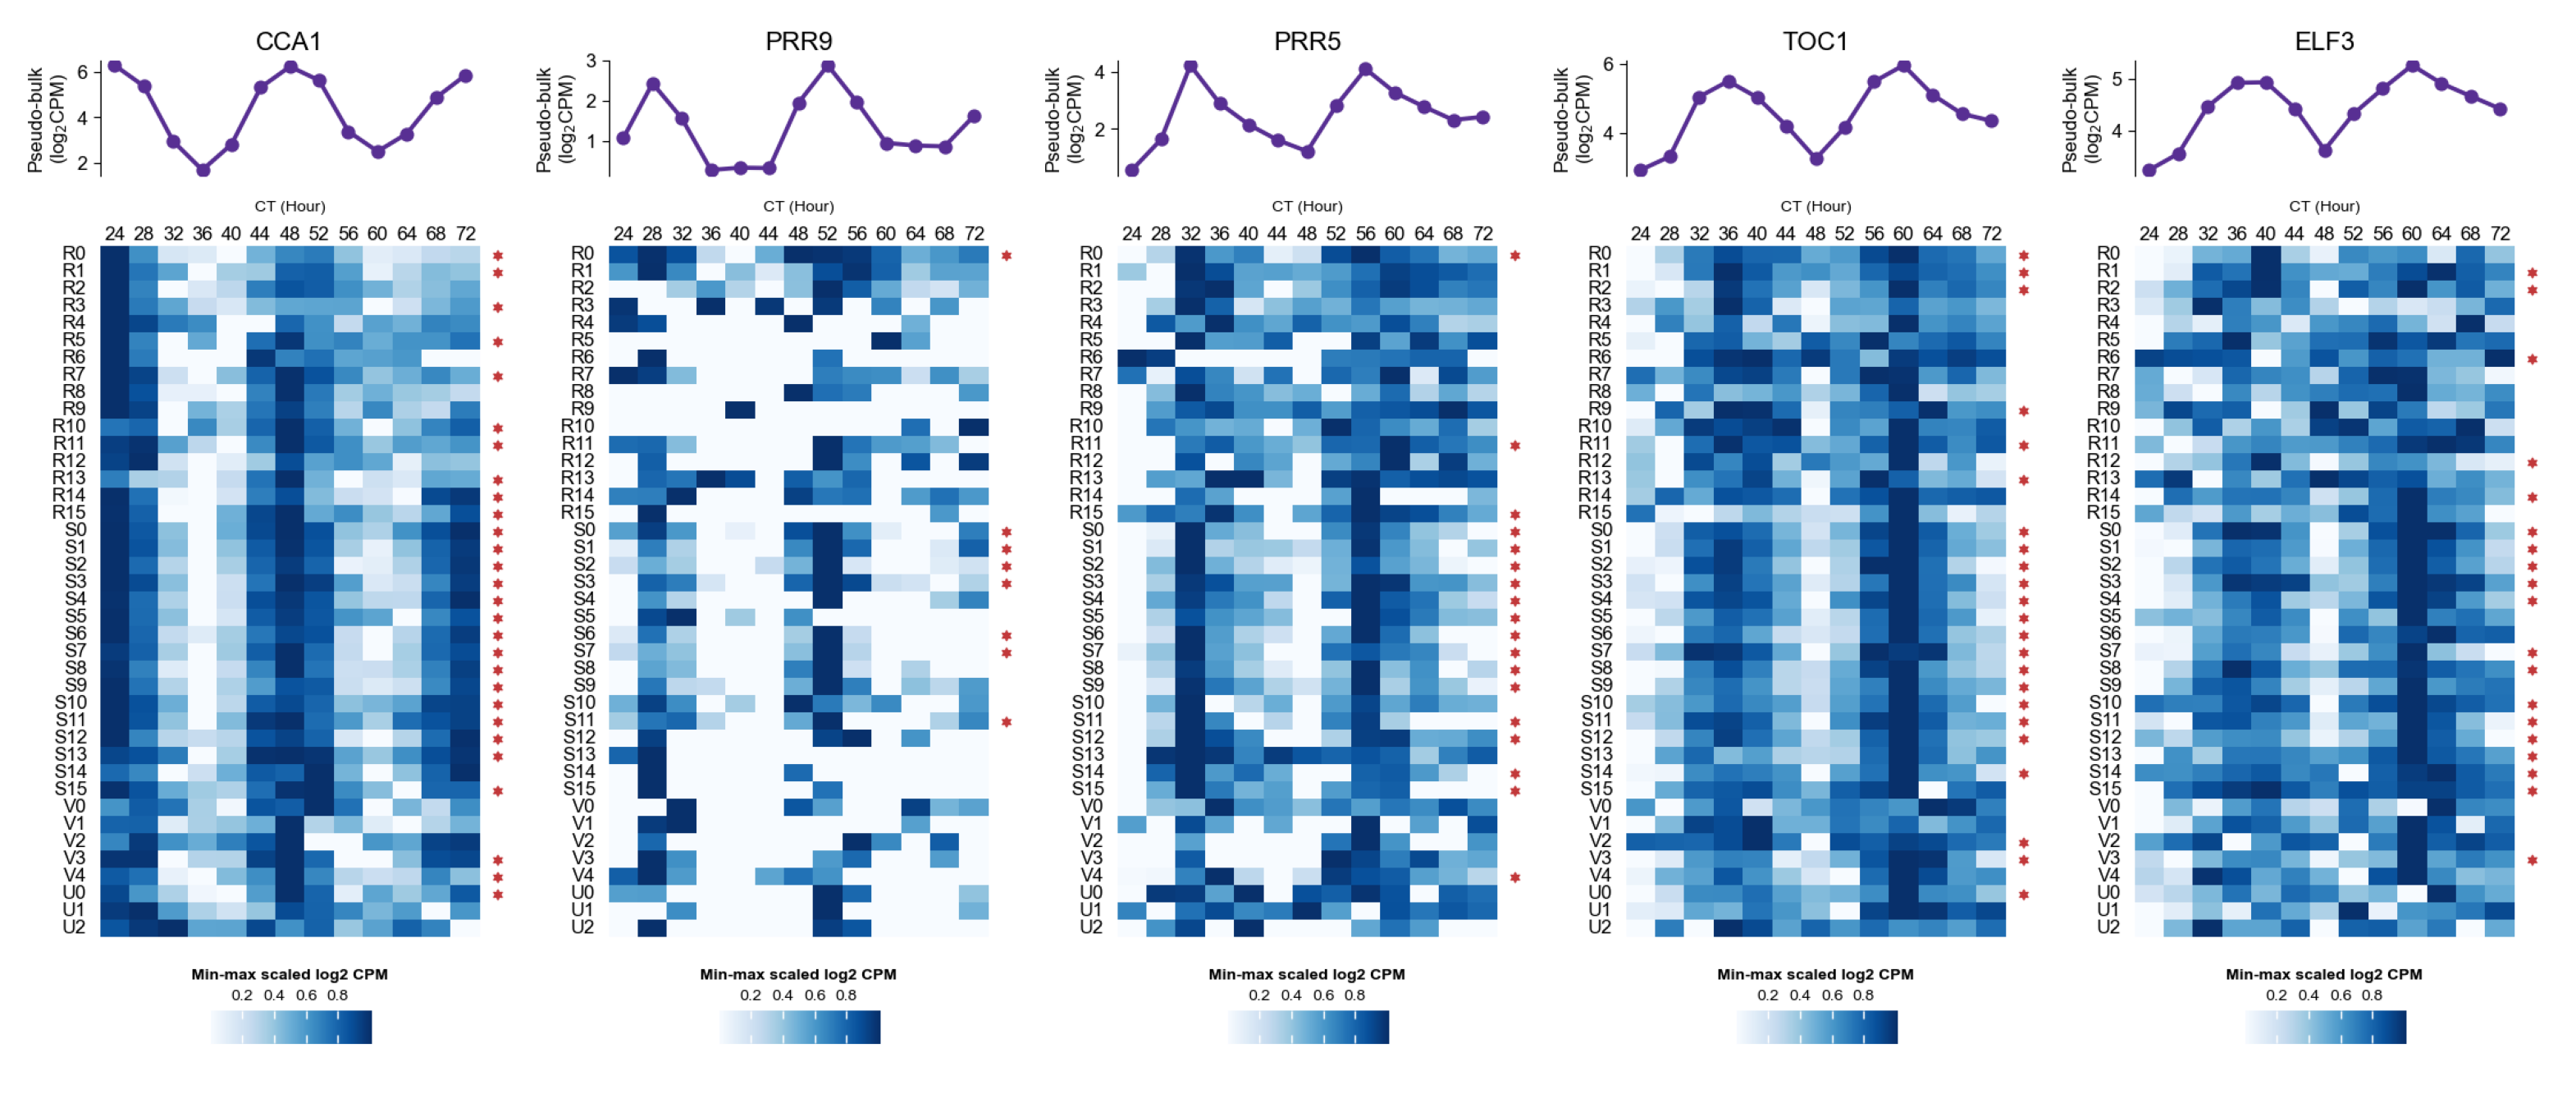

In [ ]:
figc = FigConcateWrap()
for name, gene in {
    "CCA1": "AT2G46830",
    "PRR9": "AT2G46790",
    "PRR5": "AT5G24470",
    "TOC1": "AT5G61380",
    "ELF3": "AT2G25930",
}.items():
    h = plotGeneUsingCircadianStyle(ead, gene, df_jtkCpm, name)
    ax = h.figure.axes[-3]
    ax.set_ylabel("Pseudo-bulk\n(log$_2$CPM)")
    ax.yaxis.label.set_visible(True)
    figc.addFig(
        FigConcate(ax.figure)
    )
figc.wrapAndGenerate(5).show((20, 20))

[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]


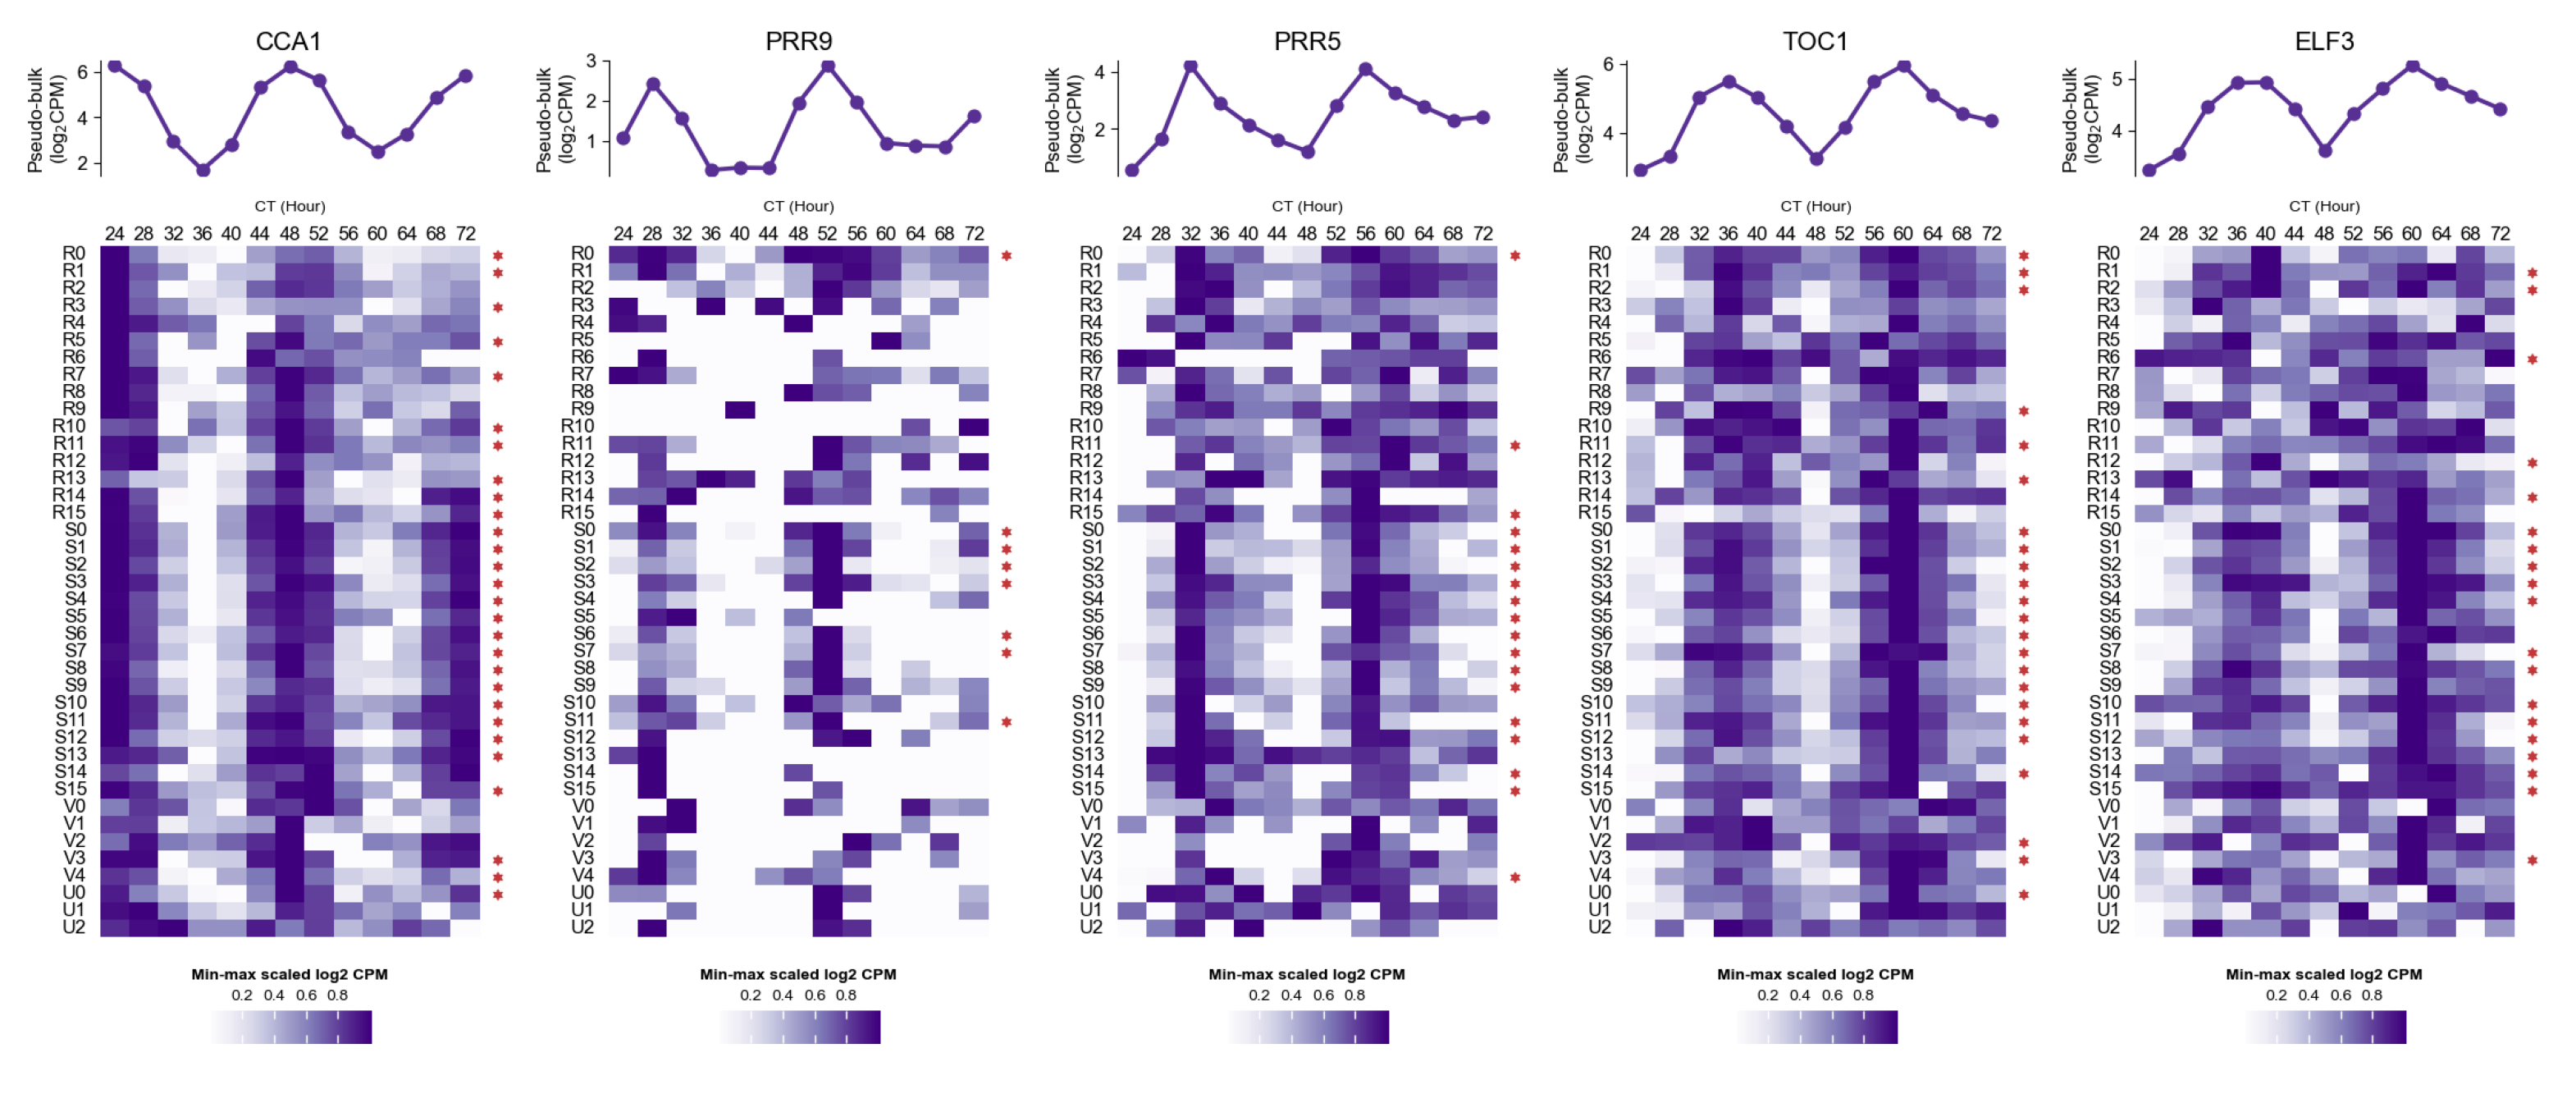

In [ ]:
figc = FigConcateWrap()
for name, gene in {
    "CCA1": "AT2G46830",
    "PRR9": "AT2G46790",
    "PRR5": "AT5G24470",
    "TOC1": "AT5G61380",
    "ELF3": "AT2G25930",
}.items():
    h = plotGeneUsingCircadianStyle(ead, gene, df_jtkCpm, name, cmap='Purples')
    ax = h.figure.axes[-3]
    ax.set_ylabel("Pseudo-bulk\n(log$_2$CPM)")
    ax.yaxis.label.set_visible(True)
    figc.addFig(
        FigConcate(ax.figure)
    )
figc.wrapAndGenerate(5).show((20, 20))

[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, 14.0, '14'), Text(0, 16.0, '16'), Text(0, 18.0, '18'), Text(0, 20.0, '20'), Text(0, 22.0, '22'), Text(0, 24.0, '24'), Text(0, 26.0, '26'), Text(0, 28.0, '28'), Text(0, 30.0, '30'), Text(0, 32.0, '32'), Text(0, 34.0, '34')]
[Text(0, 15.0, '15.0'), Text(0, 17.5, '17.5'), Text(0, 20.0, '20.0'), Text(0, 22.5, '22.5'), Text(0, 25.0, '25.0'), Text(0, 27.5, '27.5'), Text(0, 30.0, '30.0'), Text(0, 32.5, '32.5'), Text(0, 35.0, '35.0'), Text(0, 37.5, '37.5')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40'), Text(0, 45.0, '45')]


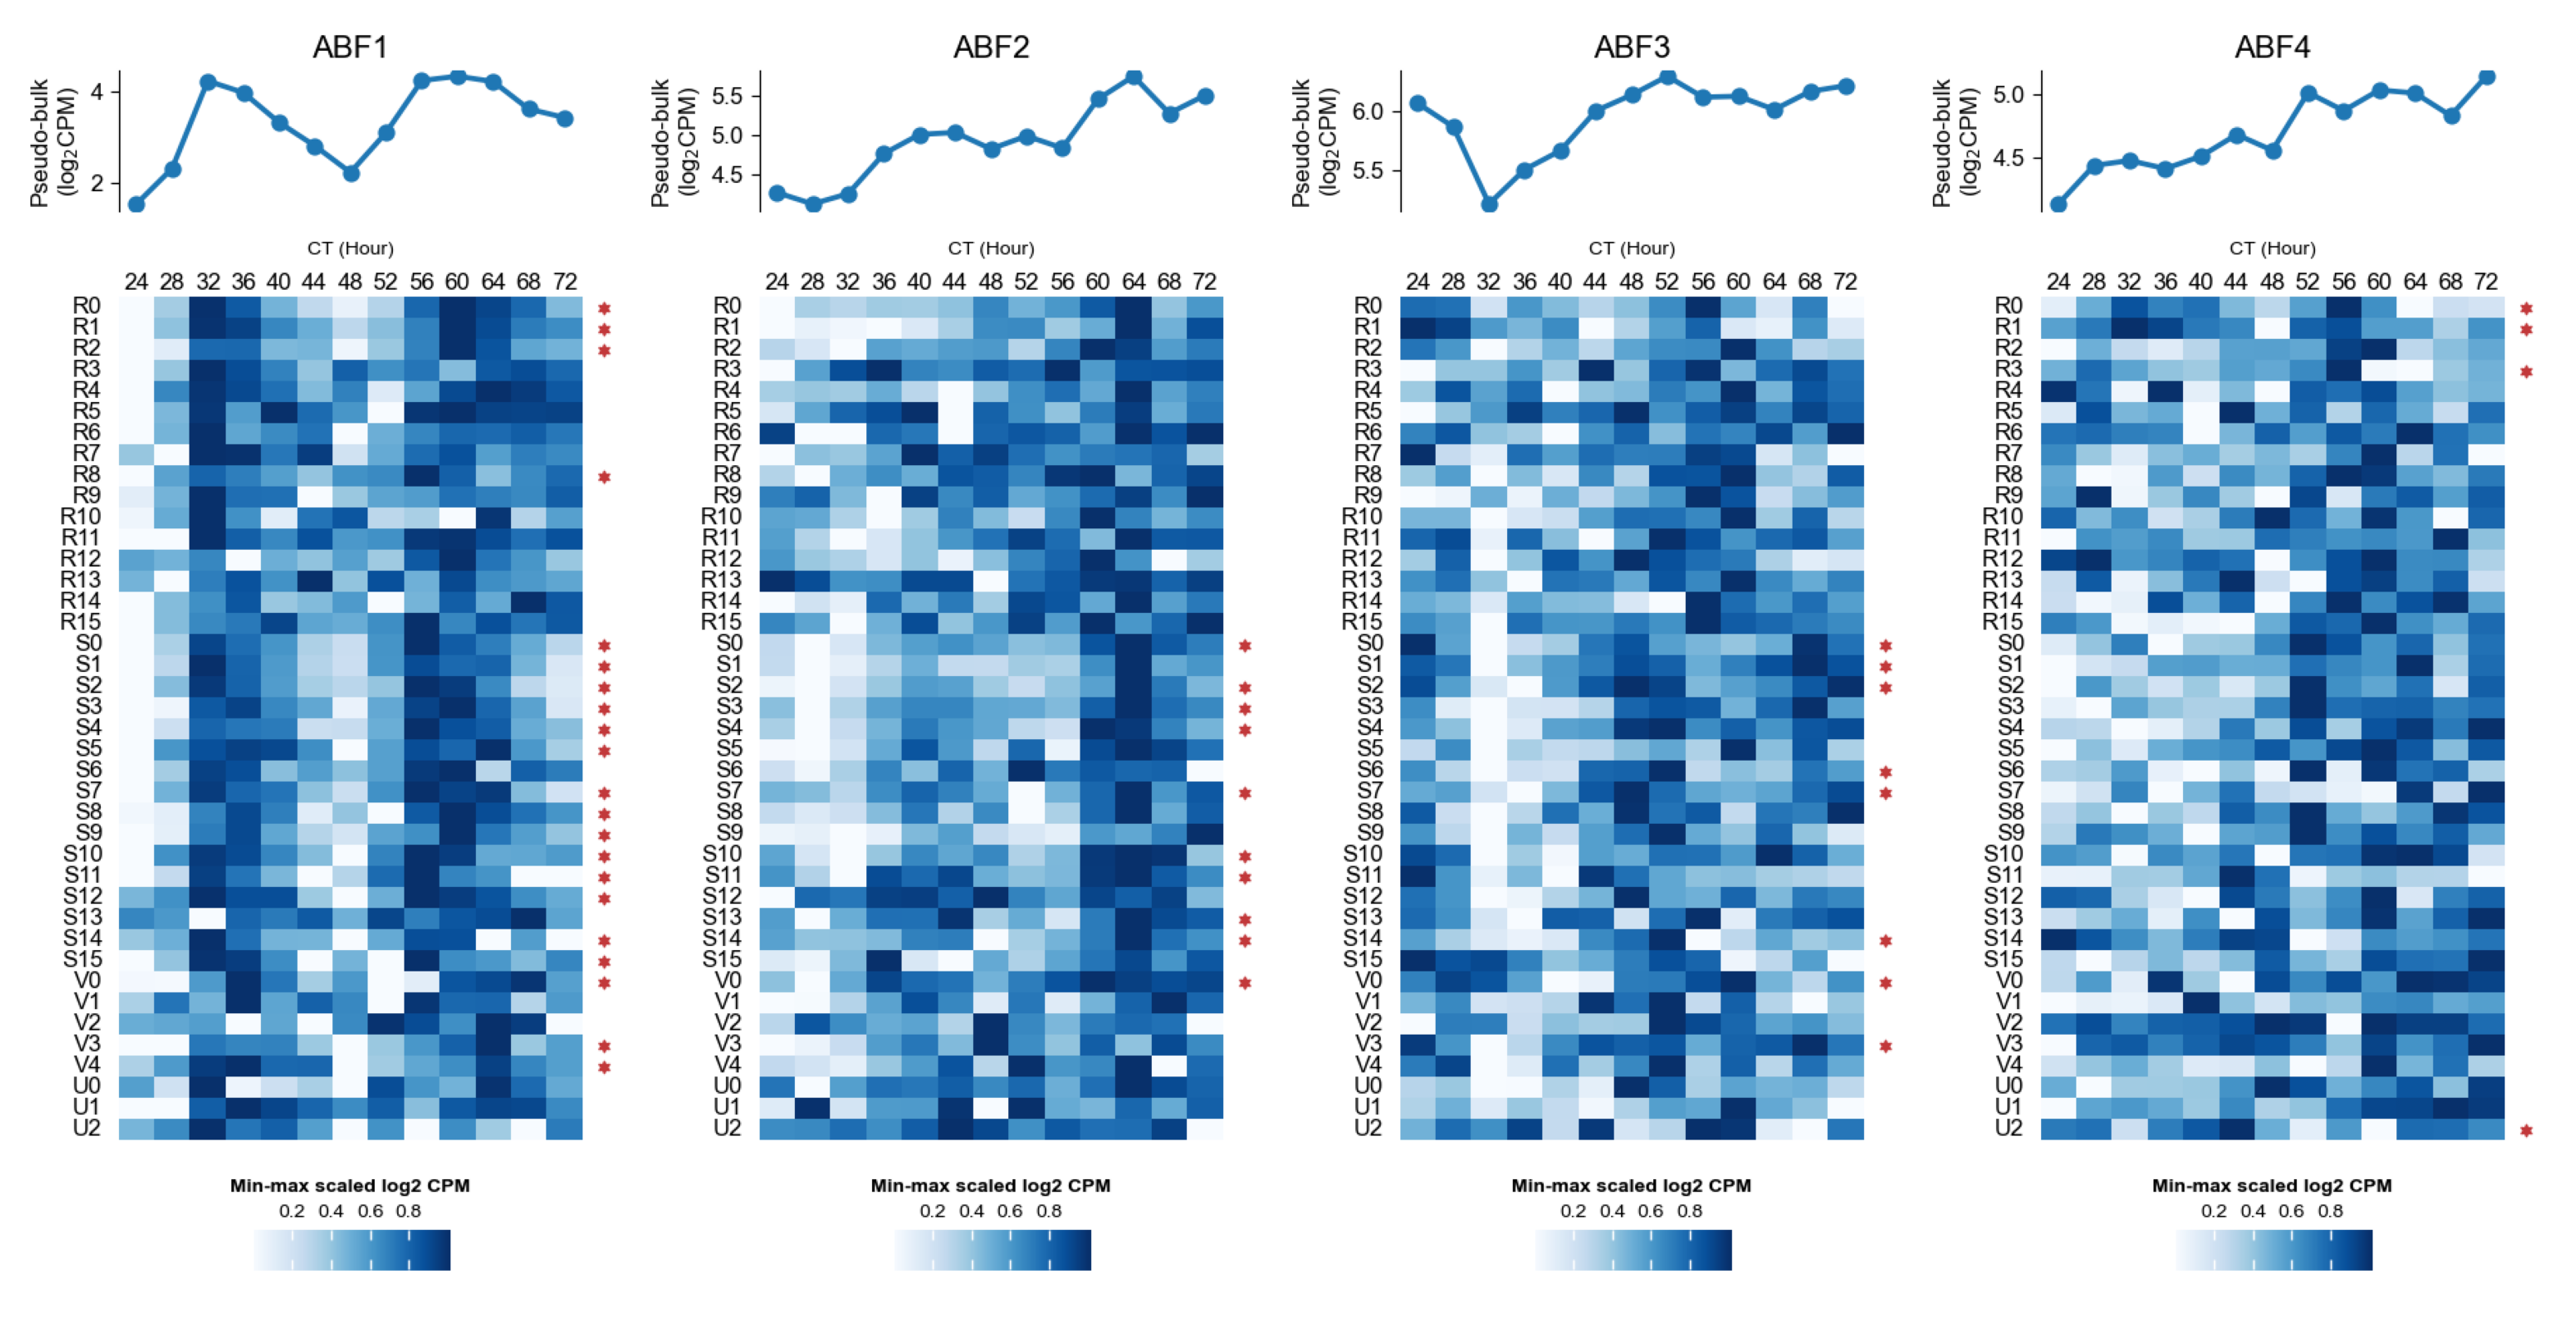

In [ ]:
figc = FigConcateWrap()
for gene, name in dt_abf.items():
    h = plotGeneUsingCircadianStyle(ead, gene, df_jtkCpm, name)
    ax = h.figure.axes[-3]
    ax.set_ylabel("Pseudo-bulk\n(log$_2$CPM)")
    ax.yaxis.label.set_visible(True)
    figc.addFig(
        FigConcate(ax.figure)
    )
figc.wrapAndGenerate(4).show((20, 20))

[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40')]
[Text(0, -5.0, '−5'), Text(0, 0.0, '0'), Text(0, 5.0, '5'), Text(0, 10.0, '10'), Text(0, 15.0, '15'), Text(0, 20.0, '20'), Text(0, 25.0, '25'), Text(0, 30.0, '30'), Text(0, 35.0, '35'), Text(0, 40.0, '40'), Text(0,

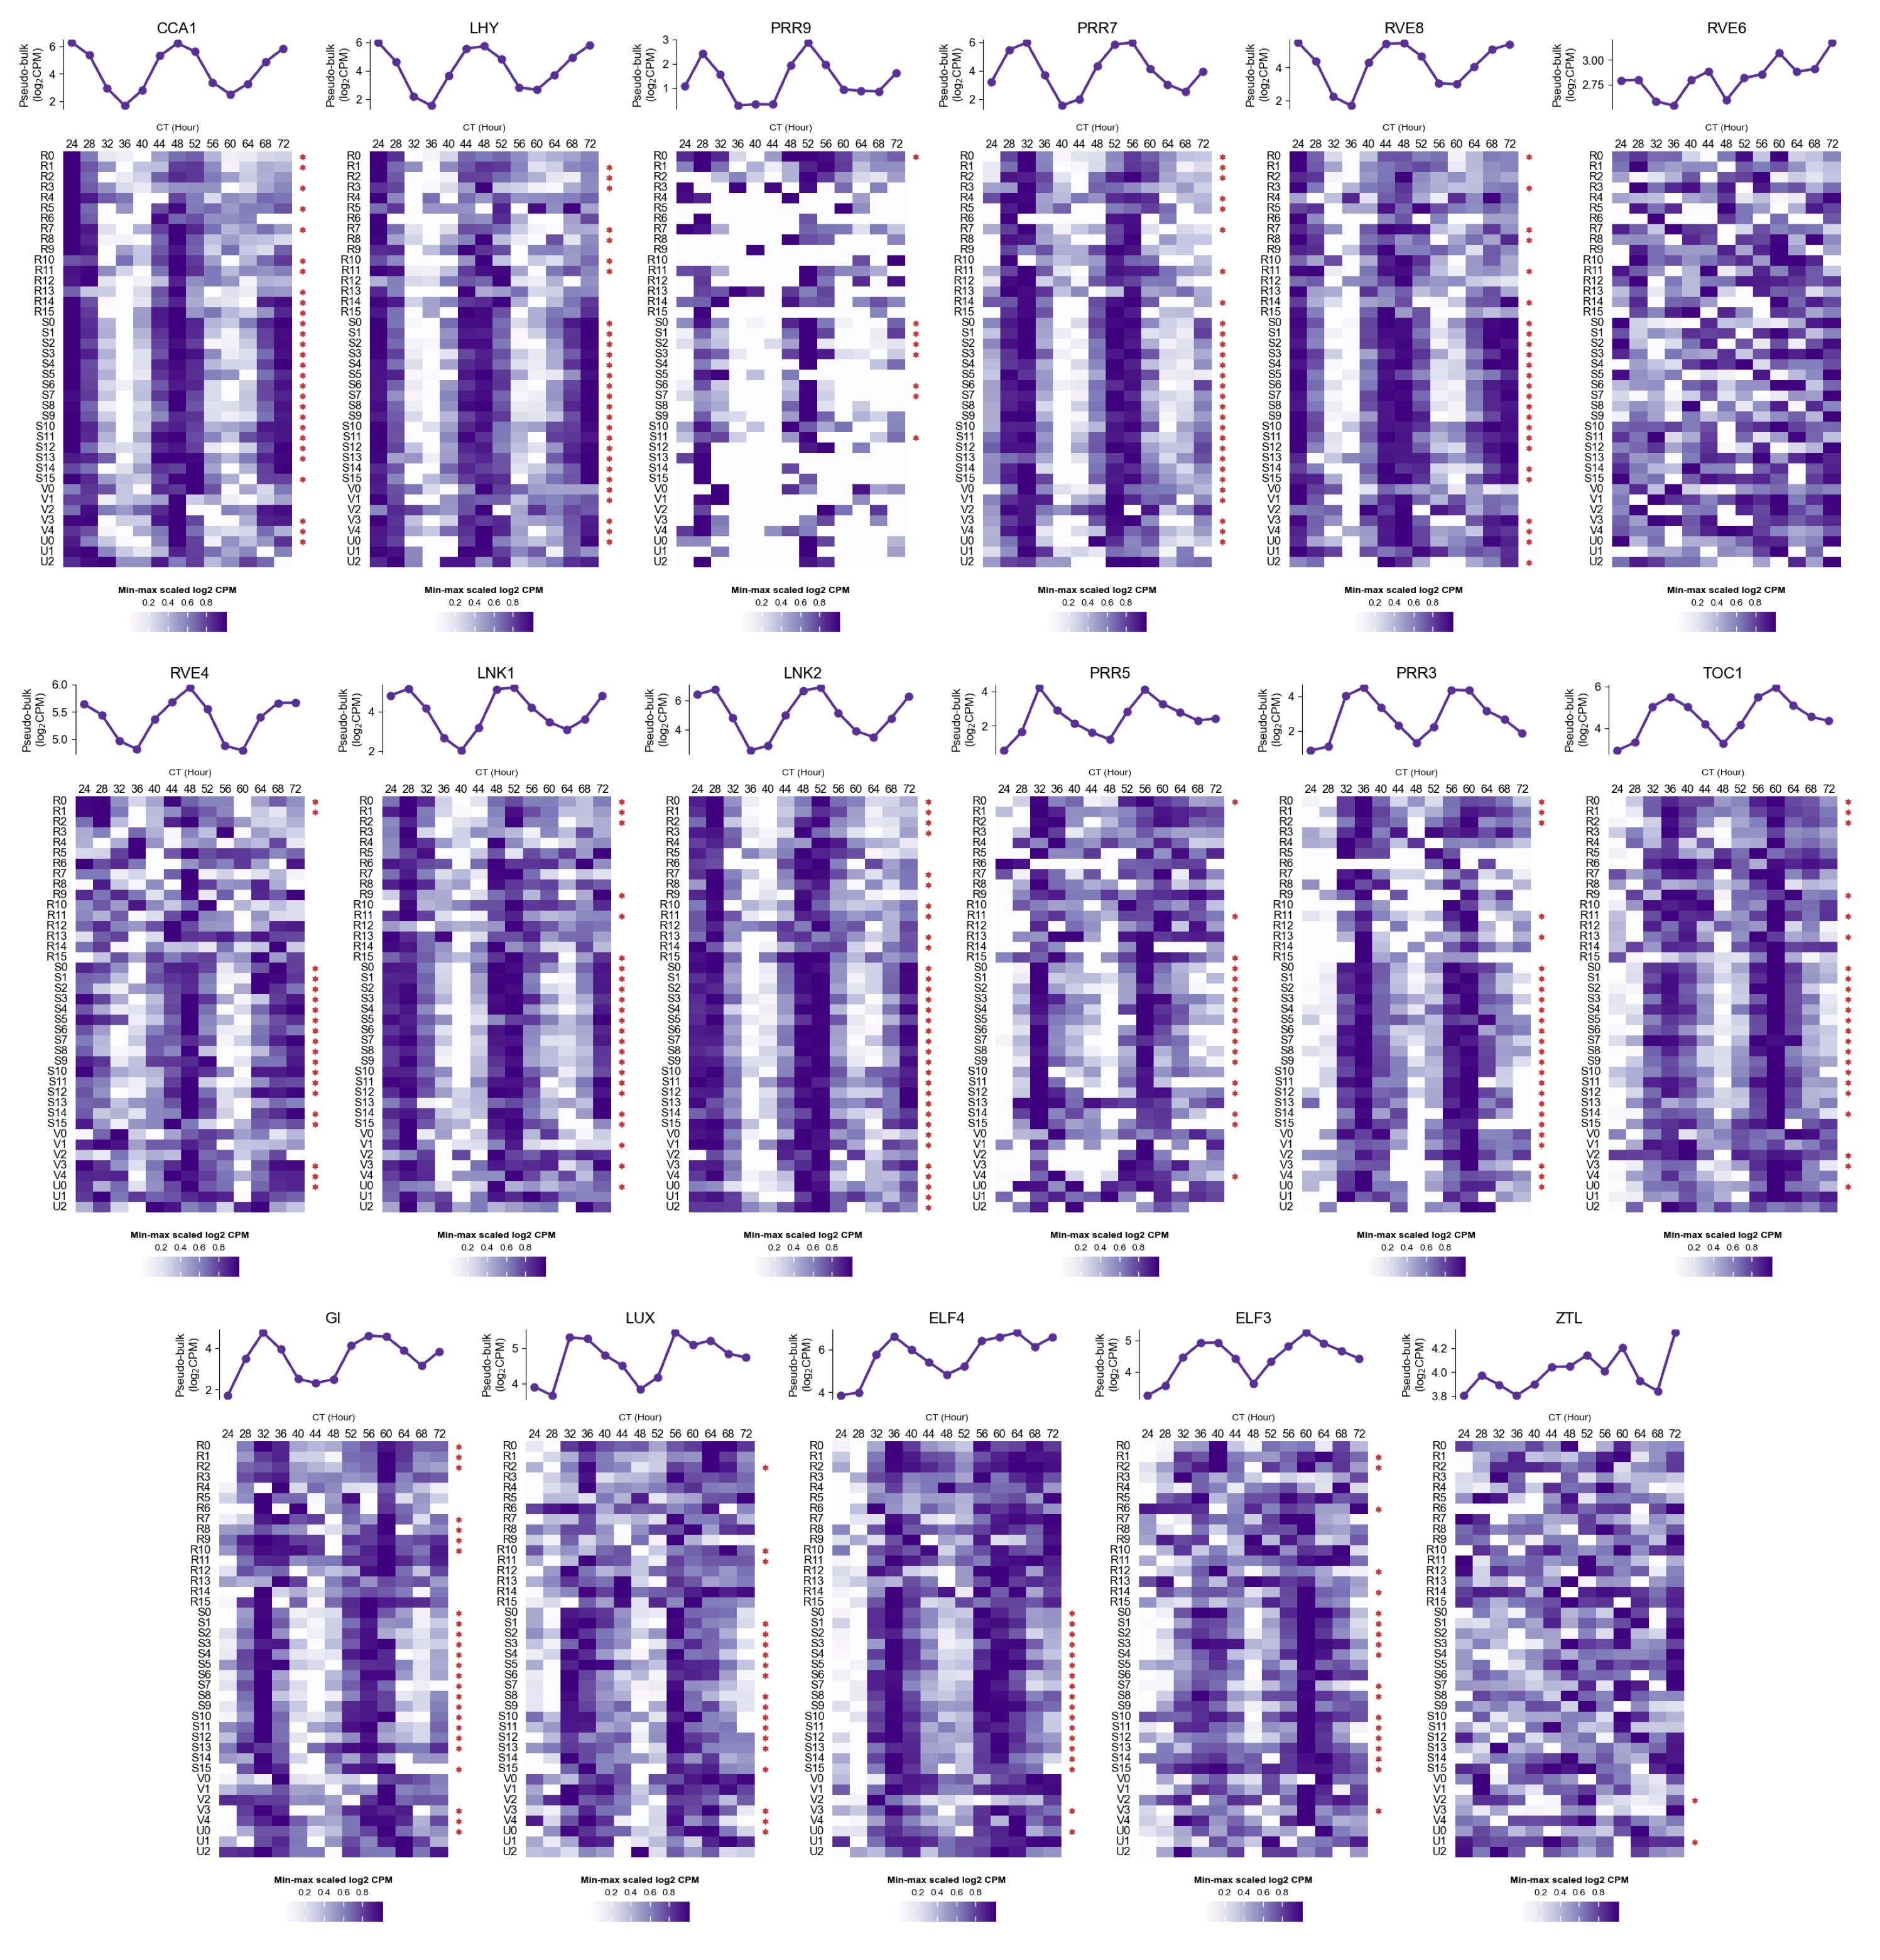

In [ ]:
ls_plotGenes = [
    "AT2G46830",
    "AT1G01060",
    "AT2G46790",
    "AT5G02810",
    "AT3G09600",
    "AT5G52660",
    "AT5G02840",
    "AT5G64170",
    "AT3G54500",
    "AT5G24470",
    "AT5G60100",
    "AT5G61380",
    "AT1G22770",
    # "AT5G59570",
    "AT3G46640",
    "AT2G40080",
    "AT2G25930",
    'AT5G57360',
]
ls_plotNames = [
    "CCA1",
    "LHY",
    "PRR9",
    "PRR7",
    "RVE8",
    "RVE6",
    "RVE4",
    "LNK1",
    "LNK2",
    "PRR5",
    "PRR3",
    "TOC1",
    "GI",
    # "BOA",
    "LUX",
    "ELF4",
    "ELF3",
    'ZTL',
]
dt_plotGenes = dict(zip(ls_plotGenes, ls_plotNames))
figc = FigConcateWrap()
for gene, name in dt_plotGenes.items():
    h = plotGeneUsingCircadianStyle(ead, gene, df_jtkCpm, name, cmap='Purples')
    ax = h.figure.axes[-3]
    ax.set_ylabel("Pseudo-bulk\n(log$_2$CPM)")
    ax.yaxis.label.set_visible(True)
    figc.addFig(
        FigConcate(ax.figure)
    )
figc.wrapAndGenerate(6).show((20, 20))

In [ ]:
from joblib import Parallel, delayed
import os
os.environ['R_HOME'] = '/datapool/home/zhijian/zhijian/miniconda3/envs/circadian/lib/R'
# os.environ['R_HOME'] = '/public/home/liuzj/softwares/anaconda3/envs/hormone/lib/R'
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
from jpy_tools.rTools import py2r, r2py, r_inline_plot, rHelp, trl, rSet, rGet, ad2so, so2ad, so2md, rcontext, Trl, r2py_re, py2r_re, RR, FR
from jpy_tools import loadPkl, toPkl
rBase = importr('base')
rUtils = importr('utils')
dplyr = importr('dplyr')
reticulate = importr('reticulate')
R = ro.r
T = Trl()
R("options(browser='firefox', shiny.port=6533, max.print=200)")
%load_ext rpy2.ipython


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

<Figure size 100x100 with 0 Axes>

In [ ]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import marsilea as ma
import marsilea.plotter as mp
# plt.rcParams['figure.dpi'] = 150
font_dirs = ["/datapool/home/zhijian/.local/share/mpl_fontkit/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
sns.despine(top=True, right=True)
from itertools import product
from functools import reduce
import patchworklib as pw
from jpy_tools.otherTools import pwRecoverSeaborn, pwStack, F, pwShow
pw.show = pwShow
fc_recoverSns = pwRecoverSeaborn()
import seaborn.objects as so
from cycler import cycler
dt_snsStyle = {**sns.axes_style('ticks'), "legend.frameon": False, "axes.spines.top":False, "axes.spines.right":False, "axes.prop_cycle":cycler(color=['grey'])}
so.Plot.config.theme.update(dt_snsStyle)
from jpy_tools.soExt import Axhline, Axvline, mvLegToAx
from jpy_tools import soExt
plt.set_loglevel('Warning')

<Figure size 640x480 with 0 Axes>

In [ ]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import scipy.sparse as ss
from tqdm import tqdm
from loguru import logger
from functools import partial
from jpy_tools import singleCellTools

In [ ]:
dir_result = "/datapool/home/zhijian/zhijian/ipf/circadian_data/"

In [ ]:
ead = singleCellTools.EnhancedAnndata(
    loadPkl(
        "beforeQc",
        lambda **dt: sc.read_h5ad(**dt),
        arg_path="filename",
        dir_path=dir_result,
    )
)

2024-07-29 15:20:17.026 | WARNING  | jpy_tools.singleCellTools:rawLayer:463 - rawLayer will be overwritten by raw and all the related objects will be re-initialized


# S MOD

In [ ]:
def _getClusterTissue(x):
    if x.startswith('R'):
        return 'Root'
    elif x.startswith('S'):
        return 'Shoot'
    elif x.startswith('V'):
        return 'Stele'
    elif x.startswith('U'):
        return 'Unknown'
    else:
        assert False

In [ ]:
from jpy_tools.overlapTools import GeneOverlapBase
from itertools import product
from jpy_tools.soExt import Axline
import scipy

In [ ]:
class GeneOverlapCircadian(GeneOverlapBase):
    def getDiffPhaseGenes(self, ls_cluster1, ls_cluster2):
        from itertools import product
        def _getDiffPhaseGenes(self, cluster1, cluster2):
            _ls = [cluster1, cluster2]
            df_diff = self.df.query("Cluster in @_ls", engine='python').pivot_table(["OrgPhase", "StdPhase"], 'Gene', 'Cluster').dropna()
            df_diff = df_diff.rename(columns={cluster1: '1', cluster2: '2'})
            df_diff.columns = ['_'.join(x) for x in df_diff.columns.ravel()]

            df_diff = df_diff.assign(
                diff = lambda _: (_[f"OrgPhase_1"] - _[f"OrgPhase_2"]).abs(),
                diff_std = lambda _: (_[f"StdPhase_1"]**2 + _[f"StdPhase_2"]**2)**0.5
            ).assign(
                diff = lambda _: np.where(_['diff']<12, _['diff'], 24-_['diff'])
            ).assign(
                zscore  = lambda _: _['diff'] / _['diff_std']
            ).assign(
                pdiff = lambda _: (1-scipy.stats.norm.cdf(_['zscore'])) * 2
            ).assign(cluster1 = cluster1, cluster2 = cluster2)
            return df_diff
        
        if isinstance(ls_cluster1, str):
            ls_cluster1 = [ls_cluster1]
        if isinstance(ls_cluster2, str):
            ls_cluster2 = [ls_cluster2]

        _ls = []
        for cluster1, cluster2 in product(ls_cluster1, ls_cluster2):
            _ls.append(_getDiffPhaseGenes(self, cluster1, cluster2))
        df_diff = pd.concat(_ls)
        return df_diff

    def plotDiffPhaseGenes(self, ls_cluster1, ls_cluster2, **kwargs):
        df_diff = self.getDiffPhaseGenes(ls_cluster1, ls_cluster2)
        p = (
            so.Plot(df_diff.query("pdiff <= 0.05"), x=f'OrgPhase_1', y=f'OrgPhase_2')
            .facet(row='cluster1', col='cluster2')
            .add(so.Dot())
            .add(Axline(linestyle='--', color='black'), x=None, y=None, data={})
            .scale(x=so.Continuous().tick(every=4), y=so.Continuous().tick(every=4))
            .layout(size=(5,5))
        )
        pp = p.plot()
        pp._repr_png_()
        fig = pp._figure
        for ax in fig.axes:
            title = ax.get_title()
            y, x = title.split('|')
            x = x.strip()
            y = y.strip()
            ax.set_xlabel(f"Cluster {x}")
            ax.set_ylabel(f"Cluster {y}")
        return p, fig

In [ ]:
ead.obs['Cluster_final'].cat.categories

Index(['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10',
       'R11', 'R12', 'R13', 'R14', 'R15', 'S0', 'S1', 'S2', 'S3', 'S4', 'S5',
       'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'V0',
       'V1', 'V2', 'V3', 'V4', 'U0', 'U1', 'U2'],
      dtype='object')

In [ ]:
df_jtkCpm: pd.DataFrame

In [ ]:
_ls_gene = df_jtkCpm['CycID'].unique().tolist()
_ls_cluster = ead.obs['Cluster_final'].cat.categories

In [ ]:
df_jtkResLong = pd.DataFrame([[x,y] for x,y in product(_ls_gene, _ls_cluster)], columns=['Gene', 'Cluster'])
df_jtkResLong = df_jtkResLong.assign(
    Lag = np.nan,
    Amp = np.nan,
    Phase = np.nan,
    OrgPhase = np.nan,
    StdPhase = np.nan,
    Bhq = np.nan,
    AdjP = np.nan
)
df_jtkResLong = df_jtkResLong.merge(df_jtkCpm, how='left', left_on=['Gene', 'Cluster'], right_on=['CycID', 'Cluster'])


In [ ]:
df_jtkResLong

Gene Cluster  Lag  Amp  Phase  OrgPhase  StdPhase  Bhq  AdjP  \
0       AT1G01650      R0  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
1       AT1G01650      R1  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
2       AT1G01650      R2  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
3       AT1G01650      R3  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
4       AT1G01650      R4  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
...           ...     ...  ...  ...    ...       ...       ...  ...   ...   
393275  AT5G56670      V3  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
393276  AT5G56670      V4  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
393277  AT5G56670      U0  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
393278  AT5G56670      U1  NaN  NaN    NaN       NaN       NaN  NaN   NaN   
393279  AT5G56670      U2  NaN  NaN    NaN       NaN       NaN  NaN   NaN   

            CycID  ...       AMP  idxMax  phase  orgPhase  stdPhase  orgAmpli  \
0       AT1G01650  ...  0.290269      R0    8.0  8.836904  1.066236  0.291260   
1             NaN  ...       NaN     NaN    NaN       NaN       NaN       NaN   
2             NaN  ...       NaN     NaN    NaN       NaN       NaN       NaN   
3             NaN  ...       NaN     NaN    NaN       NaN       NaN       NaN   
4             NaN  ...       NaN     NaN    NaN       NaN       NaN       NaN   
...           ...  ...       ...     ...    ...       ...       ...       ...   
393275        NaN  ...       NaN     NaN    NaN       NaN       NaN       NaN   
393276        NaN  ...       NaN     NaN    NaN       NaN       NaN       NaN   
393277        NaN  ...       NaN     NaN    NaN       NaN       NaN       NaN   
393278        NaN  ...       NaN     NaN    NaN       NaN       NaN       NaN   
393279  AT5G56670  ...  0.375183      U2    6.0  5.909504  1.030065  0.468061   

        stdAmpli   orgBase   stdBase  cluster  
0       0.081799  5.072276  0.057665       R0  
1            NaN       NaN       NaN      NaN  
2            NaN       NaN       NaN      NaN  
3            NaN       NaN       NaN      NaN  
4            NaN       NaN       NaN      NaN  
...          ...       ...       ...      ...  
393275       NaN       NaN       NaN      NaN  
393276       NaN       NaN       NaN      NaN  
393277       NaN       NaN       NaN      NaN  
393278       NaN       NaN       NaN      NaN  
393279  0.135574  8.869638  0.092618       U2  

[393280 rows x 24 columns]

In [ ]:
df_jtkCpm

CycID      BH.Q     ADJ.P   PER   LAG       AMP Cluster idxMax  \
59     AT1G01650  0.454435  0.001704  24.0  10.0  0.290269      R0     R0   
73     AT1G01770  0.555030  0.003172  24.0  10.0  0.585589      R0     R0   
127    AT1G02340  0.637560  0.005656  24.0   8.0  0.539486      R0     R0   
159    AT1G02730  0.991179  0.040064  24.0   6.0  0.434612      R0     R0   
165    AT1G02810  0.991179  0.040064  24.0   6.0  0.192513      R0     R0   
...          ...       ...       ...   ...   ...       ...     ...    ...   
16754  AT5G63860  1.000000  0.025736  24.0  12.0  0.509274      U2     U2   
16757  AT5G63890  1.000000  0.000872  24.0   6.0  0.946444      U2     U2   
16837  AT5G64850  1.000000  0.025736  24.0  22.0  0.136284      U2     U2   
16928  AT5G65920  1.000000  0.040064  24.0  12.0  0.526095      U2     U2   
16941  AT5G66052  1.000000  0.016053  24.0  14.0  0.497068      U2     U2   

       phase   orgPhase  stdPhase  orgAmpli  stdAmpli   orgBase   stdBase  \
59         8   8.836904  1.066236  0.291260  0.081799  5.072276  0.057665   
73        10   9.282317  0.788015  0.632981  0.129219  3.457433  0.091856   
127        8   7.566437  0.647684  0.610294  0.108654  4.482262  0.075024   
159        6   6.640111  1.718104  0.414722  0.199579  1.972184  0.136592   
165        6   5.294659  0.868642  0.265760  0.064606  6.441807  0.044234   
...      ...        ...       ...       ...       ...       ...       ...   
16754     10   9.944060  1.009348  0.894761  0.228557  4.501291  0.164424   
16757      4   4.795781  0.902952  1.413163  0.353924  3.513410  0.243341   
16837     22  21.445847  1.082108  0.223080  0.062162  6.671694  0.044323   
16928     12  12.284779  1.640697  0.903223  0.361463  3.204624  0.265128   
16941     14  14.857791  1.217775  1.090448  0.345806  3.713420  0.245174   

      cluster  
59         R0  
73         R0  
127        R0  
159        R0  
165        R0  
...       ...  
16754      U2  
16757      U2  
16837      U2  
16928      U2  
16941      U2  

[37254 rows x 16 columns]

In [ ]:

df_jtkResLong = df_jtkResLong.assign(
    Lag = lambda _: _.phase,
    Amp = lambda _: _.AMP,
    Phase = lambda _: _.phase,
    OrgPhase = lambda _: _.orgPhase,
    StdPhase = lambda _: _.stdPhase,
    Bhq = lambda _: _['ADJ.P'],
    AdjP = lambda _: _['ADJ.P']
).drop(columns=[x for x in df_jtkCpm.columns if x != 'Cluster'])
df_jtkResLong['IsCircadian'] = np.where(np.isnan(df_jtkResLong['Phase']), 'False', 'True')
df_jtkResLong

Gene Cluster  Lag       Amp  Phase  OrgPhase  StdPhase       Bhq  \
0       AT1G01650      R0  8.0  0.290269    8.0  8.836904  1.066236  0.001704   
1       AT1G01650      R1  NaN       NaN    NaN       NaN       NaN       NaN   
2       AT1G01650      R2  NaN       NaN    NaN       NaN       NaN       NaN   
3       AT1G01650      R3  NaN       NaN    NaN       NaN       NaN       NaN   
4       AT1G01650      R4  NaN       NaN    NaN       NaN       NaN       NaN   
...           ...     ...  ...       ...    ...       ...       ...       ...   
393275  AT5G56670      V3  NaN       NaN    NaN       NaN       NaN       NaN   
393276  AT5G56670      V4  NaN       NaN    NaN       NaN       NaN       NaN   
393277  AT5G56670      U0  NaN       NaN    NaN       NaN       NaN       NaN   
393278  AT5G56670      U1  NaN       NaN    NaN       NaN       NaN       NaN   
393279  AT5G56670      U2  6.0  0.375183    6.0  5.909504  1.030065  0.040064   

            AdjP IsCircadian  
0       0.001704        True  
1            NaN       False  
2            NaN       False  
3            NaN       False  
4            NaN       False  
...          ...         ...  
393275       NaN       False  
393276       NaN       False  
393277       NaN       False  
393278       NaN       False  
393279  0.040064        True  

[393280 rows x 10 columns]

In [ ]:
from types import MethodType

In [ ]:
# go_jtk.dotplot = MethodType(GeneOverlapBase.dotplot, go_jtk)
# go_jtk.tileplot = MethodType(GeneOverlapBase.tileplot, go_jtk)

In [ ]:
go_jtk = GeneOverlapCircadian(df_jtkResLong, 'Gene', groupKey='Cluster', categoryKey='IsCircadian', categoryTarget='True')

In [ ]:
go_jtk.getOverlapInfo(diagS=1e-323)

100%|██████████| 1600/1600 [00:55<00:00, 28.70it/s] 


In [ ]:
go_jtk.df_overlapInfo.pivot_table(index='comp1', columns='comp2', values='smod').index.map(_getClusterTissue)

Index(['Root', 'Root', 'Root', 'Root', 'Root', 'Root', 'Root', 'Root', 'Root',
       'Root', 'Root', 'Root', 'Root', 'Root', 'Root', 'Root', 'Shoot',
       'Shoot', 'Shoot', 'Shoot', 'Shoot', 'Shoot', 'Shoot', 'Shoot', 'Shoot',
       'Shoot', 'Shoot', 'Shoot', 'Shoot', 'Shoot', 'Shoot', 'Shoot',
       'Unknown', 'Unknown', 'Unknown', 'Stele', 'Stele', 'Stele', 'Stele',
       'Stele'],
      dtype='object', name='comp1')

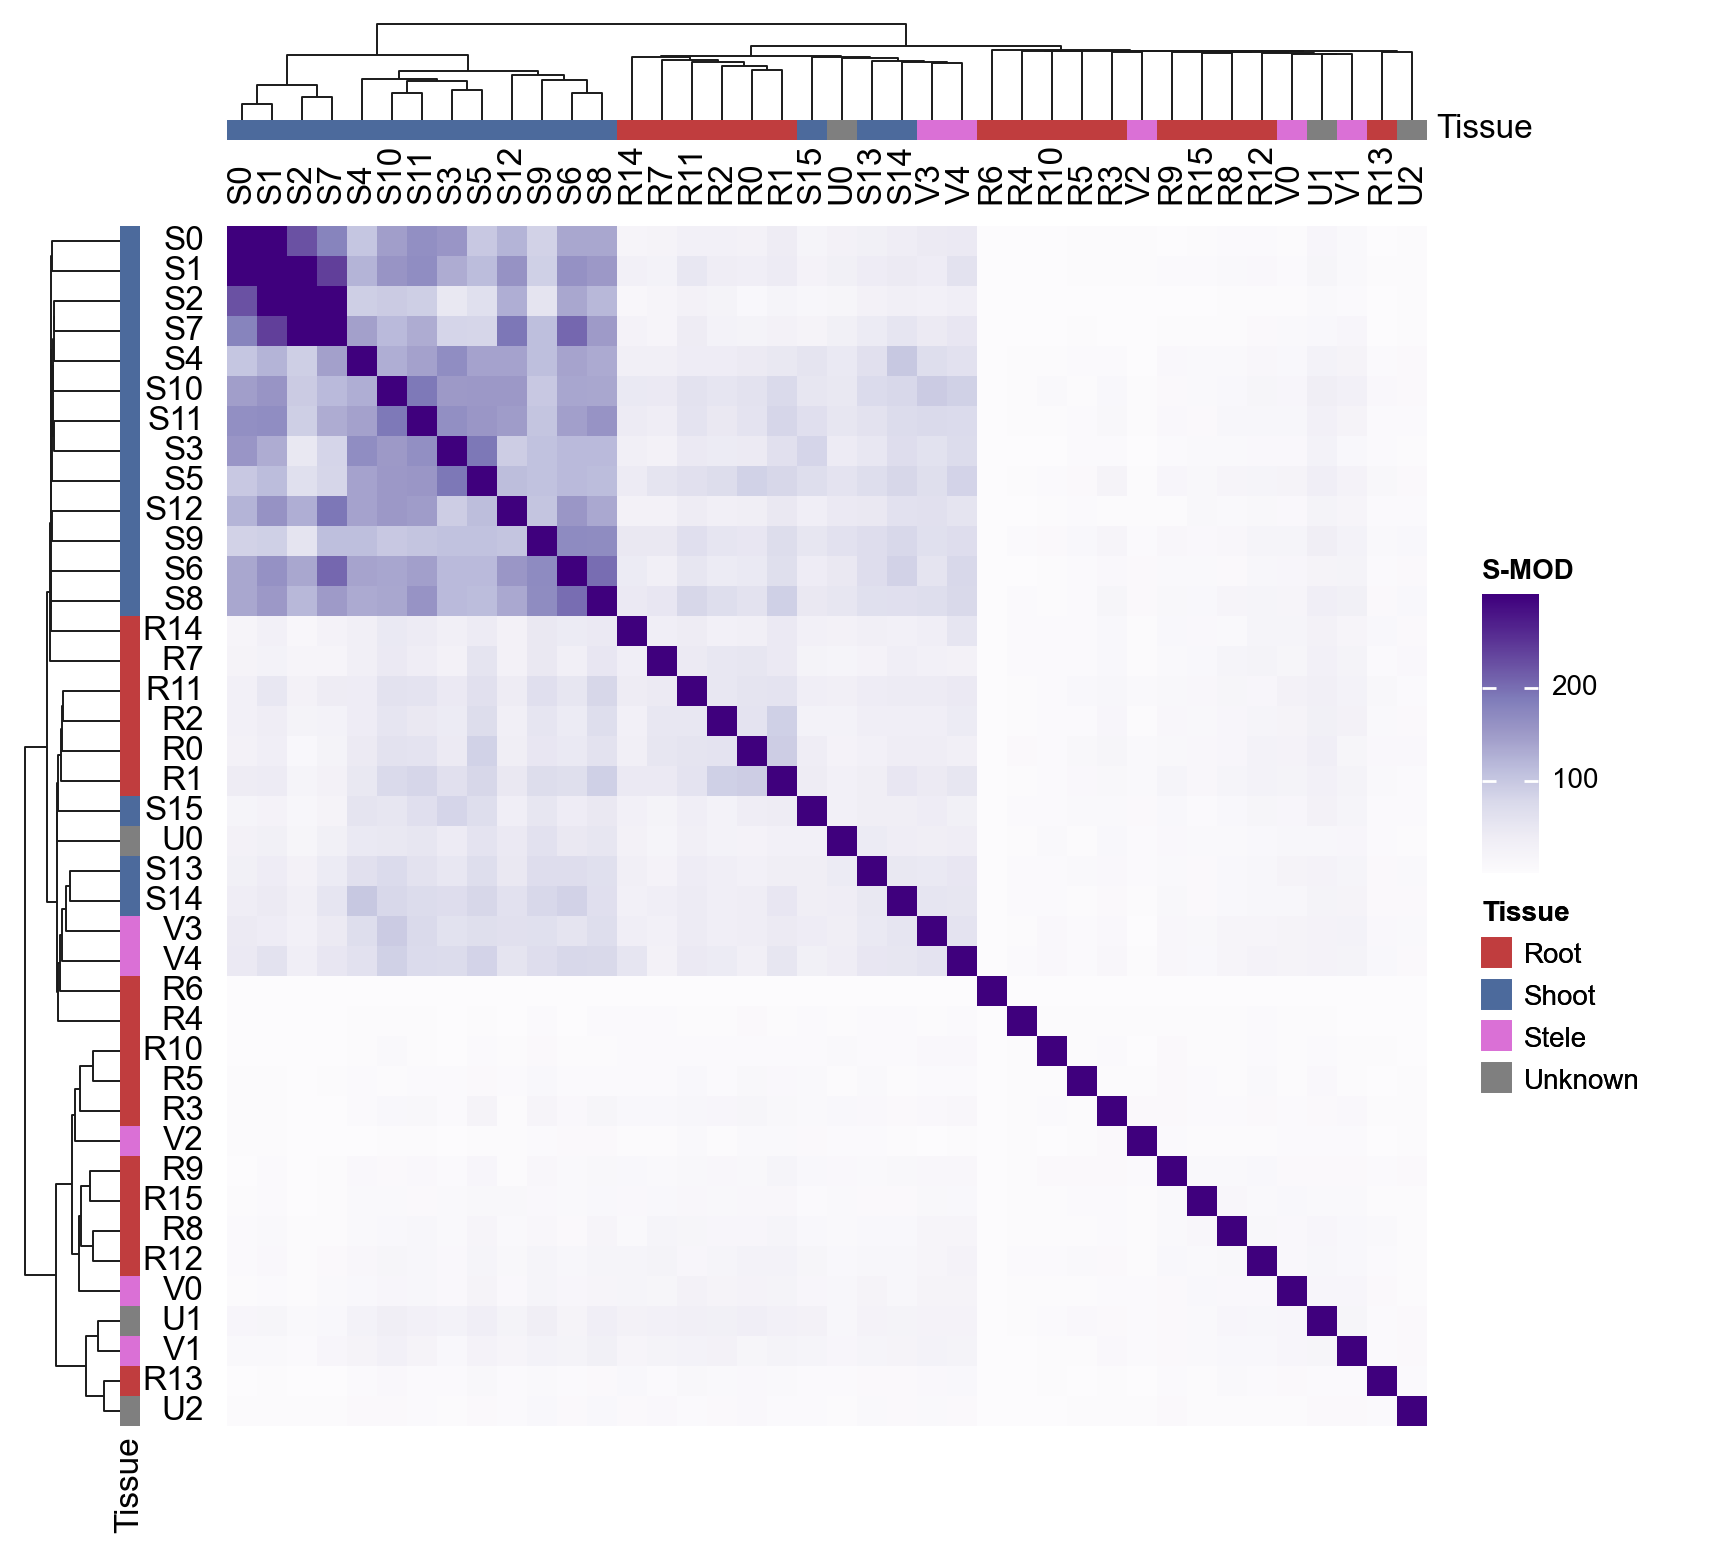

In [ ]:
h = go_jtk.tileplot(vmax=300, cmap="Purples", addCounts=False, width=6, height=6)
linkage = scipy.cluster.hierarchy.linkage(h._deform.get_data(), method="average")
h.add_left(
    mp.Colors(
        go_jtk.df_overlapInfo.pivot_table(
            index="comp1", columns="comp2", values="smod"
        ).index.map(_getClusterTissue),
        palette={
            "Root": "#c03d3e",
            "Shoot": "#4c6a9c",
            "Stele": "#da70d6",
            "Unknown": "#7f7f7f",
        },
        label="Tissue",
    ),
    size=0.1,
)

h.add_top(
    mp.Colors(
        go_jtk.df_overlapInfo.pivot_table(
            index="comp1", columns="comp2", values="smod"
        ).index.map(_getClusterTissue),
        palette={
            "Root": "#c03d3e",
            "Shoot": "#4c6a9c",
            "Stele": "#da70d6",
            "Unknown": "#7f7f7f",
        },
        label="Tissue",
    ),
    size=0.1,
    legend=False,
)

h.add_dendrogram("left", linkage=linkage)
h.add_dendrogram("top", linkage=linkage)
h.render()